In [ ]:
!pip install torchnet

In [ ]:
import subprocess
import os
import sys
import glob
import json
import shutil
from PIL import Image
from collections import Counter
import numpy as np
import pandas as pd
from random import sample
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from collections import Counter
import torchvision
from torchvision import datasets, transforms
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torchvision import models
from torch.utils.data import DataLoader
import torchnet as tnt
import time
from scipy.interpolate import interp1d
import subprocess
import requests
from urllib.request import urlretrieve
import tarfile
import copy

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### utils

In [ ]:
def get_number_processors():
    """Get the number of processors in a CPU.
    Returns:
        num (int): Number of processors.
    Examples:
        >>> get_number_processors()
        4
    """
    try:
        num = os.cpu_count()
    except Exception:
        import multiprocessing #force exception in case mutiprocessing is not installed
        num = multiprocessing.cpu_count()
    return num


def get_gpu_name():
    """Get the GPUs in the system
    Examples:
        >>> get_gpu_name()
        ['Tesla M60', 'Tesla M60', 'Tesla M60', 'Tesla M60']
        
    """
    try:
        out_str = subprocess.run(["nvidia-smi", "--query-gpu=gpu_name", "--format=csv"], stdout=subprocess.PIPE).stdout
        out_list = out_str.decode("utf-8").split('\n')
        out_list = out_list[1:-1]
        return out_list
    except Exception as e:
        print(e)


def get_gpu_memory():
    """Get the memory of the GPUs in the system
    Examples:
        >>> get_gpu_memory()
        ['8123 MiB', '8123 MiB', '8123 MiB', '8123 MiB']

    """
    try:
        out_str = subprocess.run(["nvidia-smi", "--query-gpu=memory.total", "--format=csv"], stdout=subprocess.PIPE).stdout
        out_list = out_str.decode("utf-8").replace('\r','').split('\n')
        out_list = out_list[1:-1]
        return out_list
    except Exception as e:
        print(e)

        
def get_cuda_version():
    """Get the CUDA version
    Examples:
        >>> get_cuda_version()
        'CUDA Version 8.0.61'

    """
    if sys.platform == 'win32':
        raise NotImplementedError("Implement this!")
    elif sys.platform == 'linux':
        path = '/usr/local/cuda/version.txt'
        if os.path.isfile(path):
            with open(path, 'r') as f:
                data = f.read().replace('\n','')
            return data
        else:
            return "No CUDA in this machine"
    elif sys.platform == 'darwin':
        raise NotImplementedError("Find a Mac with GPU and implement this!")
    else:
        raise ValueError("Not in Windows, Linux or Mac")
        
    
def format_dictionary(dct, indent=4):
    """Formats a dictionary to be printed
    Parameters:
        dct (dict): Dictionary.
        indent (int): Indentation value.
    Returns:
        result (str): Formatted dictionary ready to be printed
    Examples:
        >>> dct = {'bkey':1, 'akey':2}
        >>> print(format_dictionary(dct))
        {
            "akey": 2,
            "bkey": 1
        }
    """
    return json.dumps(dct, indent=indent, sort_keys=True)



def get_filenames_in_folder(folderpath):
    """ Return the files names in a folder.
    Parameters:
        folderpath (str): folder path
    Returns:
        number (list): list of files
    Examples:
        >>> get_filenames_in_folder('C:/run3x/codebase/python/minsc')
        ['paths.py', 'system_info.py', '__init__.py']

    """
    names = [os.path.basename(x) for x in glob.glob(os.path.join(folderpath, '*'))]
    return sorted(names)


def get_files_in_folder_recursively(folderpath):
    """ Return the files inside a folder recursivaly.
    Parameters:
        folderpath (str): folder path
    Returns:
        filelist (list): list of files
    Examples:
        >>> get_files_in_folder_recursively(r'C:\\run3x\\codebase\\command_line')
        ['linux\\compress.txt', 'linux\\paths.txt', 'windows\\resources_management.txt']
    """
    if folderpath[-1] != os.path.sep: #Add final '/' if it doesn't exist
        folderpath += os.path.sep
    names = [x.replace(folderpath,'') for x in glob.iglob(folderpath+'/**', recursive=True) if os.path.isfile(x)]
    return sorted(names)



def _make_directory(directory):
    """Make a directory"""
    if not os.path.isdir(directory):
        os.makedirs(directory)

        
def _create_sets_folders(root_folder, sets_names, target_folder):
    """Create folder structure"""
    for s in sets_names:
        dest = os.path.join(root_folder, s, target_folder)
        _make_directory(dest)
          
                
def split_list(py_list, perc_size=[0.8, 0.2], shuffle=False):
    """Split a list in weighted chunks
    Parameters:
        py_list (list): A list of elements.
        perc_size (list): The percentual size of each chunk size.
        shuffle (bool): Shuffle the list or not
    Returns:
        result_list (list of list): A list of lists with the chunks.
    Examples:
        >>> split_list(list(range(7)),[0.47,0.33,0.2])
        [[0, 1, 2], [3, 4, 5], [6]]
        >>> split_list(list(range(10)),[0.6,0.4], True)
        [[1, 2, 3, 6, 9, 5], [4, 8, 0, 7]]

    """
    assert sum(perc_size) == 1, "Percentage sizes do not sum to 1"
    l = py_list[:]
    if shuffle:
        random.shuffle(l)
    # Turn percentages into values between 0 and 1
    splits = np.cumsum(perc_size)

    # Split doesn't need last percent, it will just take what is left
    splits = splits[:-1]

    # Turn values into indices
    splits *= len(l)

    # Turn double indices into integers.
    splits = splits.round().astype(np.int)

    return [list(chunks) for chunks in np.split(l, splits)]


def split_dataset_folder(root_folder, dest_folder, sets_names=['train','val'], sets_sizes=[0.8,0.2], shuffle=False, verbose=False):
    """Split the folders in a dataset to pytorch format. If the intial format is:
    --class1
    ----img1.jpg
    ----img2.jpg
    --class2
    ----img1.jpg
    ----img2.jpg
    It transforms it into:
    --train
    ----class1
    ------img1.jpg
    ----class2
    ------img1.jpg
    --val
    ----class1
    ------img2.jpg
    ----class2
    ------img2.jpg   

    """
    assert sum(sets_sizes) == 1, "Data set sizes do not sum to 1"
    for folder in get_filenames_in_folder(root_folder):
        if verbose: print("Folder: ", folder)
        _create_sets_folders(dest_folder, sets_names, folder)
        files = get_filenames_in_folder(os.path.join(root_folder, folder))
        files_split = split_list(files, sets_sizes, shuffle)
        for split, set_name in zip(files_split, sets_names):
            for f in split:
                orig = os.path.join(root_folder, folder, f)
                dest = os.path.join(dest_folder, set_name, folder)
                if verbose: print("Copying {} into {}".format(orig, dest))
                shutil.copy2(orig, dest)

                
def convert_image_dataset_to_grayscale(root_folder, dest_folder, verbose=False):
    """Convert all the images from a dataset in disk to grayscale"""
    files = get_files_in_folder_recursively(root_folder)
    for f in files:
        filename = os.path.join(root_folder, f)
        if verbose: print("Converting {} to grayscale".format(filename))
        img = Image.open(filename)
        img_gray = img.convert('L')
        dest = os.path.join(dest_folder, f)
        try:
            img_gray.save(dest)
        except FileNotFoundError as e:
            if verbose: print(e)
            path = os.path.dirname(dest)
            if verbose: print("Creating folder {}".format(path))
            os.makedirs(path)
            img_gray.save(dest)
            
            
def create_dataset(data_dir, batch_size=32, sets=['train', 'val'], verbose=False):
    """Create a dataset object given the path. On data_dir there should be a train and validation folder
    and in each of them there should be the folders containing the data. One folder for each class
    """
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in sets}
    dataloaders = {x: DataLoader(image_datasets[x], 
                                 batch_size=batch_size, 
                                 shuffle=True, 
                                 num_workers=get_number_processors()) 
                   for x in sets}

    if verbose:
        dataset_sizes = {x: len(image_datasets[x]) for x in sets}
        class_names = dataloaders[sets[0]].dataset.class_to_idx
        print("There are {} clases in the dataset: {}".format(len(class_names), format_dictionary(class_names)))
        print("Sets sizes: ", format_dictionary(dataset_sizes))
        for x in sets:   
            c = Counter(item[1] for item in image_datasets[x])
            c = dict(c)
            print("Number of items in set {}: {}".format(x, c))
    return dataloaders


def plot_pytorch_data_stream(dataobject, max_images=8, title=True):
    """Plot a batch of images"""
    inputs, classes = next(iter(dataobject))  
    if max_images > dataobject.batch_size:
        max_images = dataobject.batch_size
        print("Plotting only {} images, which is the batch size".format(max_images))
    inputs = inputs[:max_images,:,:,:]
    classes = classes[:max_images]
    out = torchvision.utils.make_grid(inputs)
    inp = out.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(10,3))
    plt.imshow(inp)
    plt.axis('off')
    if title:
        class_names = dataobject.dataset.classes
        names = [class_names[x] for x in classes]
        plt.title(names)

        
def finetune(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=False):
    """Finetune all the layers of a model using a dataset loader. """
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_ft = models.__dict__[model_name](pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_ft = nn.DataParallel(model_ft)
    model_ft = model_ft.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    # All parameters are being optimized
    optimizer = SGD(model_ft.parameters(), lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_ft = train_model(dataloaders, model_ft, sets, criterion, optimizer, exp_lr_scheduler, 
                           num_epochs=num_epochs, verbose=verbose)
    return model_ft


def freeze_and_train(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=False):
    """Freezes all layers but the last one and train the last layer using a dataset loader"""
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_conv = models.__dict__[model_name](pretrained=True)
    for param in model_conv.parameters(): #params have requires_grad=True by default
        param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_conv = nn.DataParallel(model_conv)
    model_conv = model_conv.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    # Only parameters of final layer are being optimized 
    if num_gpus > 1:
        params = model_conv.module.fc.parameters()
    else:
        params = model_conv.fc.parameters()
    optimizer = SGD(params, lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_conv = train_model(dataloaders, model_conv, sets, criterion, optimizer, exp_lr_scheduler, 
                             num_epochs=num_epochs, verbose=verbose)
    return model_conv


def freeze_and_train2(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=False):
    """Freezes all layers but the last two and train the last two layers using a dataset loader"""
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_conv = models.__dict__[model_name](pretrained=True)
    for i,param in enumerate(model_conv.parameters()): #params have requires_grad=True by default
        if i >= 57:
          break
        param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_conv = nn.DataParallel(model_conv)
    model_conv = model_conv.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    params = model_conv.parameters()
    optimizer = SGD(params, lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_conv = train_model(dataloaders, model_conv, sets, criterion, optimizer, exp_lr_scheduler, 
                             num_epochs=num_epochs, verbose=verbose)
    return model_conv


def freeze_and_train3(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=False):
    """Freezes half layers """
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_conv = models.__dict__[model_name](pretrained=True)
    s = sample(range(0,60,3),10)
    for i,param in enumerate(model_conv.parameters()): #params have requires_grad=True by default
        if i in s:
          param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_conv = nn.DataParallel(model_conv)
    model_conv = model_conv.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    params = model_conv.parameters()
    optimizer = SGD(params, lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_conv = train_model(dataloaders, model_conv, sets, criterion, optimizer, exp_lr_scheduler, 
                             num_epochs=num_epochs, verbose=verbose)
    return model_conv


def freeze_and_train4(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=False):
    """Freezes all layers but the last two and train the last two layers using a dataset loader"""
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_conv = models.__dict__[model_name](pretrained=True)
    for i,param in enumerate(model_conv.parameters()): #params have requires_grad=True by default
        if i >= 30:
          break
        param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_conv = nn.DataParallel(model_conv)
    model_conv = model_conv.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    params = model_conv.parameters()
    optimizer = SGD(params, lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_conv = train_model(dataloaders, model_conv, sets, criterion, optimizer, exp_lr_scheduler, 
                             num_epochs=num_epochs, verbose=verbose)
    return model_conv


def train_model(dataloaders, model, sets, criterion, optimizer, scheduler, num_epochs=25, verbose=False):
    """Train a pytorch model"""
    since = time.time()
    dataset_sizes = {x: len(dataloaders[x].dataset) for x in sets}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    num_classes = len(dataloaders[sets[0]].dataset.classes)
    confusion_matrix = tnt.meter.ConfusionMeter(num_classes, normalized=False)
    metrics = {'train_acc':[],'val_acc':[],'train_loss':[],'val_loss':[], 'cm':[]}
    for epoch in range(num_epochs):
        if verbose:
            print('\nEpoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in sets:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
                confusion_matrix.reset()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                    confusion_matrix.add(outputs.data, labels.data)
                    
                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            #metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if verbose: print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                metrics['train_acc'].append(epoch_acc)
                metrics['train_loss'].append(epoch_loss)
            else:
                metrics['val_acc'].append(epoch_acc)
                metrics['val_loss'].append(epoch_loss)
                cm = confusion_matrix.value().copy()
                metrics['cm'].append(cm)
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    if verbose:
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics


def available_models():
    """Return available pytorch models, callable using `models.__dict__[name]`"""
    model_names = sorted(name for name in models.__dict__  if name.islower() and not name.startswith("__") and 
                         callable(models.__dict__[name]))
    return model_names


def plot_metrics(metrics, title=None):
    """Plot metrics from training. metrics is a dict containing 'train_acc', 'val_acc', 'train_loss' and
    'val_loss', each of them contains the metrics values in a list"""
    max_epochs = len(metrics['train_acc']) + 1
    epochs = range(1, max_epochs)
    epochs_dx = np.linspace(epochs[0], epochs[-1], num=max_epochs*4, endpoint=True)

    train_acc = []
    for i in range(EPOCHS):
      train_acc.append(metrics['train_acc'][i].cpu().float()) 
    val_acc = []
    for i in range(EPOCHS):
      val_acc.append(metrics['val_acc'][i].cpu().float())

    s_train_acc = interp1d(epochs, train_acc, kind='cubic')    
    s_val_acc = interp1d(epochs, val_acc, kind='cubic')    
    s_train_loss = interp1d(epochs, metrics['train_loss'], kind='cubic')    
    s_val_loss = interp1d(epochs, metrics['val_loss'], kind='cubic')    

    fig, ax = plt.subplots(1, 2)
    fig.subplots_adjust(right=2, top=0.85)
    if title is not None:
        st = fig.suptitle(title, fontsize=16)
        st.set_x(1)
    ax[0].plot(epochs, train_acc, 'b.', label='train')
    ax[0].plot(epochs_dx, s_train_acc(epochs_dx), 'b')
    ax[0].plot(epochs, val_acc, 'g.', label='val')
    ax[0].plot(epochs_dx, s_val_acc(epochs_dx), 'g')
    ax[0].legend( loc="lower right")
    ax[0].set_title("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].xaxis.set_major_locator(MultipleLocator(1)) #only integers in axis multiples of 1
    
    ax[1].plot(epochs, metrics['train_loss'], 'b.', label='train')
    ax[1].plot(epochs_dx, s_train_loss(epochs_dx), 'b')
    ax[1].plot(epochs, metrics['val_loss'], 'g.', label='val')
    ax[1].plot(epochs_dx, s_val_loss(epochs_dx), 'g')
    ax[1].legend(loc="upper right")
    ax[1].set_title("Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].xaxis.set_major_locator(MultipleLocator(1))
    plt.show()
    
    
def _list_lsun_categories(tag):
    """List LSUN categories"""
    url = 'http://lsun.cs.princeton.edu/htbin/list.cgi?tag=' + tag
    f = requests.get(url)
    return json.loads(f.text)


def _download_lsun(out_dir, category, set_name, tag):
    """Download a specific category of LSUN"""
    url = 'http://lsun.cs.princeton.edu/htbin/download.cgi?tag={tag}' \
          '&category={category}&set={set_name}'.format(**locals())
    if set_name == 'test':
        out_name = 'test_lmdb.zip'
    else:
        out_name = '{category}_{set_name}_lmdb.zip'.format(**locals())
    _make_directory(out_dir)
    out_path = os.path.join(out_dir, out_name)
    cmd = ['curl', url, '-o', out_path]
    print('Downloading', category, set_name, 'set')
    subprocess.call(cmd)  
    
    
def download_lsun_dataset(out_dir):
    """Download LSUN dataset and create pytorch folder structure
    source: https://github.com/fyu/lsun
    """
    tag = 'latest'
    categories = _list_lsun_categories(tag)
    print('Downloading', len(categories), 'categories')
    for category in categories:
        _download_lsun(out_dir, category, 'train', tag)
        _download_lsun(out_dir, category, 'val', tag)
    #_download_lsun(args.out_dir, '', 'test', args.tag)

    
def download_caltech256(out_dir):
    """Download Caltech256 dataset"""
    url = 'http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar'
    if len(os.listdir(out_dir)) != 0:
        print("Dataset already donwloaded in {}".format(out_dir)) 
    else:
        print("Downloading {}".format(url))
        filepath = os.path.join(out_dir, 'delete.me')
        fname, h = urlretrieve(url, filepath)
        print("Extracting files from {}".format(fname))
        with tarfile.open(fname) as tar:
            tar.extractall(path=out_dir)
        os.remove(fname)


In [ ]:
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

### connect to Google

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Model and utilities

The first step is to define the `finetune` and `freeze_and_train` routines. In addition, we list all the models avaialable in pytorch that we could potentially use as a base model.

In [ ]:
model_names = available_models()
print(model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'googlenet', 'inception_v3', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'wide_resnet101_2', 'wide_resnet50_2']


## Datasets

We are going to use different datasets to test the transfer learning routines. We converted all of them to grayscale to analyze how the network behaves with in this color space. We also had to divide the dataset folders into `train` and `validation`, following the structure of pytorch. All the steps to do this are in the notebook [data_prep.ipynb](data_prep.ipynb).

Links to source:
* [Hymenoptera](https://download.pytorch.org/tutorial/hymenoptera_data.zip), 2 classes and 397 images.
* [Simpons](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/data), 20 classes (subset of total) and 19548 images.
* [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data), 2 classes and 25000 images.
* [Caltech 256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar), 257 classes (yeah, I was also surprised) and 30607 images.

In [ ]:
DATA_ROOT = '/content/drive/My Drive/STAT8002/datadrive'

HYMENOPTERA_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_data')
SIMPSONS_ROOT = os.path.join(DATA_ROOT, 'simpsons')
DOGS_CATS_ROOT = os.path.join(DATA_ROOT, 'dogs_vs_cats')

Here we define the initial parameters.

In [ ]:
MODEL_NAME = 'resnet18'
BATCH_SIZE = 16
SETS = ['train', 'val']
NUM_GPUS = 4
EPOCHS = 15
LR = 0.001
LR_STEP = 0.1
LR_EPOCHS = 10
MOMENTUM = 0.9

Now we are going to load each of the datasets, showing some internal stats for each of them.

In [ ]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT, batch_size=BATCH_SIZE)

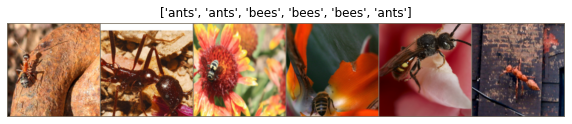

In [ ]:
plot_pytorch_data_stream(data_hymenoptera['train'], max_images=6)

## Training

For each dataset, we are going to compute finetunining and freeze and train. 

**NOTE:** As of now (Dec 2017), PyTorch implementation of parallel data computation is ineficient, so it takes almost the same time to compute finetuning and freezing with 4 GPUs. With 1 GPU freezing is around 2.5 faster than finetuning. They have a [PR](https://github.com/pytorch/pytorch/pull/4216) to solve this. For more info, please refer to this [issue](https://github.com/miguelgfierro/sciblog_support/issues/50).

In [ ]:
val_acc_ft = "Validation accuracy finetuning"
val_acc_fr1 = "Freeze and train last one layer"
val_acc_fr2 = "Freeze and train last two layers"
val_acc_fr3 = "Freeze and train random half of layers"
val_acc_fr4 = "Freeze and train last half of layers"
df = pd.DataFrame(columns=[val_acc_ft, val_acc_fr1, val_acc_fr2, val_acc_fr3, val_acc_fr4])


### Hymenoptera dataset

In [ ]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT, batch_size=BATCH_SIZE)
model, metrics = finetune(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


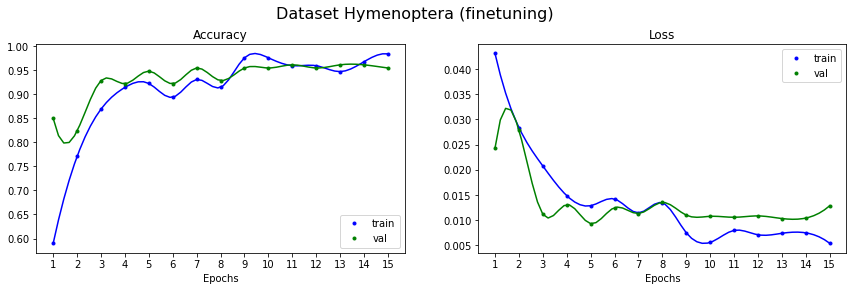

In [ ]:
dataset_name = "Dataset Hymenoptera"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc']).cpu().numpy()

In [ ]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT, batch_size=BATCH_SIZE)
model, metrics = freeze_and_train(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


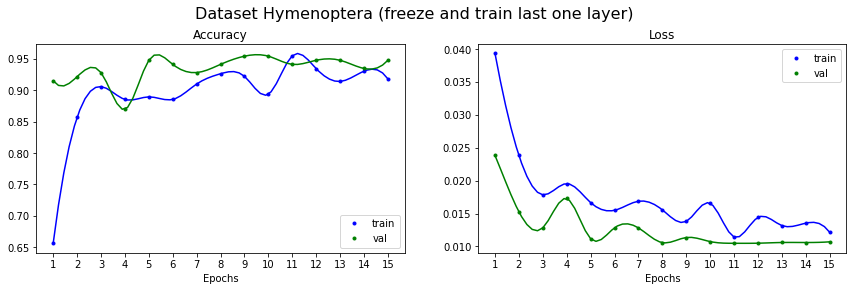

In [ ]:
plot_metrics(metrics, dataset_name + " (freeze and train last one layer)")
df.at[dataset_name, val_acc_fr1] = max(metrics['val_acc']).cpu().numpy()

In [ ]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT, batch_size=BATCH_SIZE)
model, metrics = freeze_and_train2(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


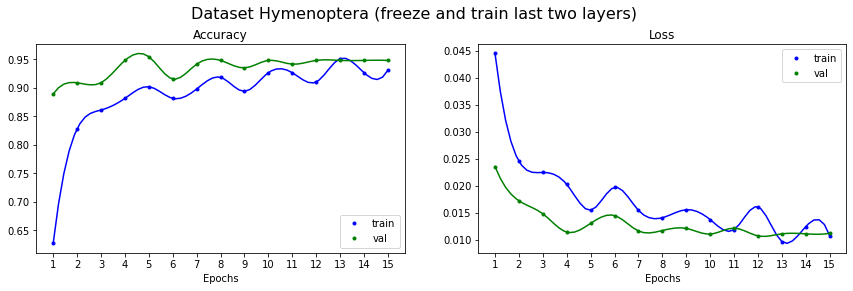

In [ ]:
plot_metrics(metrics, dataset_name + " (freeze and train last two layers)")
df.at[dataset_name, val_acc_fr2] = max(metrics['val_acc']).cpu().numpy()

In [ ]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT, batch_size=BATCH_SIZE)
model, metrics = freeze_and_train3(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


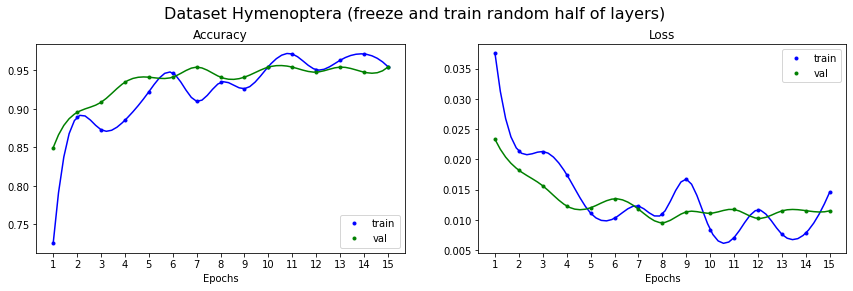

In [ ]:
plot_metrics(metrics, dataset_name + " (freeze and train random half of layers)")
df.at[dataset_name, val_acc_fr3] = max(metrics['val_acc']).cpu().numpy()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


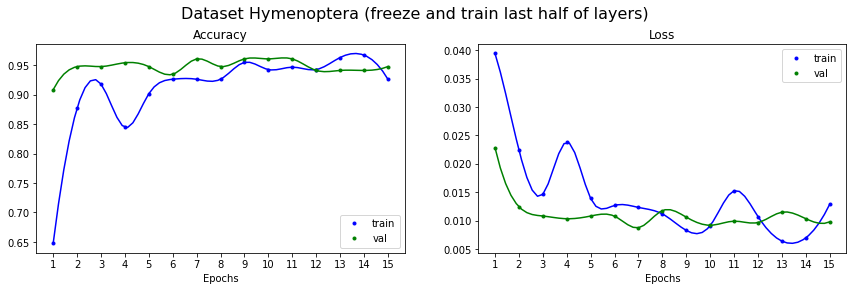

In [ ]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT, batch_size=BATCH_SIZE)
model, metrics = freeze_and_train4(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

plot_metrics(metrics, dataset_name + " (freeze and train last half of layers)")
df.at[dataset_name, val_acc_fr4] = max(metrics['val_acc']).cpu().numpy()

In [ ]:
df

,Validation accuracy finetuning,Freeze and train last one layer,Freeze and train last two layers,Freeze and train random half of layers,Freeze and train last half of layers
Dataset Hymenoptera,0.9607843,0.95424837,0.95424837,0.95424837,0.9607843
